(3, 512, 512)


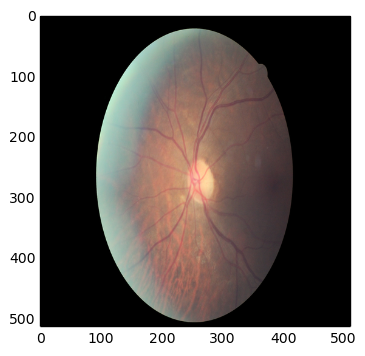

In [24]:
import matplotlib.pyplot as plt
import caffe
import os, csv
import numpy as np
from PIL import Image

new_width = new_height = 512

# Point this to the location of the training images
train_dir = "../retinopathy/train/"

fnames = os.listdir(train_dir)
fnames = np.random.choice(fnames, 3500)

im = Image.open("10_left.jpeg")
res = im.resize((new_width, new_height), Image.ANTIALIAS)
img = np.array(res)
# plt.imshow(img)
img = np.swapaxes(img, 0, 2)
print img.shape

## Caffe network construction

In [25]:
# Change this to the name of the deploy prototxt file. For example, if you are using alexnet, then put
# deploy_alexnet.prototxt
model = "deploy_alexnet.prototxt"

# This shoud point to the corresponding caffemodel in results/
weights = "../alexnet/alexnet_iter_2000.caffemodel"

# Sets up the network
net = caffe.Net(str(model), str(weights), caffe.TEST)

In [26]:
# We will take 10 sample images as that is the what the deploy prototxt requires
sample = np.random.choice(fnames, 10)
print "We have %i images" % len(fnames)
print sample

We have 3500 images
['35232_left.jpeg' '23856_right.jpeg' '37957_left.jpeg' '43062_left.jpeg'
 '2407_right.jpeg' '13038_left.jpeg' '25197_left.jpeg' '40754_right.jpeg'
 '19160_left.jpeg' '43470_right.jpeg']


In [27]:
sample_images = []
for f in sample:
    im = Image.open(train_dir + f)
    res = im.resize((new_width, new_height), Image.ANTIALIAS)
    img = np.array(res)
    img = np.swapaxes(img, 0, 2)
    sample_images.append(img)

CPU times: user 13.7 s, sys: 268 µs, total: 13.7 s
Wall time: 14.6 s


In [28]:
# Make sure shape is good
np.array(sample_images).shape

(10, 3, 512, 512)

In [29]:
im_input = np.array(sample_images)
net.blobs["data"].reshape(*im_input.shape)
net.blobs["data"].data[...] = im_input

In [30]:
# Inference
res = net.forward()

CPU times: user 49.3 s, sys: 28.6 s, total: 1min 17s
Wall time: 36 s


In [31]:
# This outputs the softmax probabilities
res["loss"]

array([[ 0.73403114,  0.06871501,  0.14480837,  0.02556635,  0.02687914],
       [ 0.73563093,  0.06855324,  0.14425798,  0.02517298,  0.02638475],
       [ 0.73383635,  0.06861296,  0.14517187,  0.02552497,  0.02685391],
       [ 0.73235661,  0.06877574,  0.1465122 ,  0.02553878,  0.02681667],
       [ 0.73263317,  0.06878052,  0.14632171,  0.0254268 ,  0.02683783],
       [ 0.73470831,  0.06881407,  0.14460325,  0.02534361,  0.02653081],
       [ 0.7364735 ,  0.06852579,  0.14372276,  0.0250965 ,  0.02618143],
       [ 0.73581415,  0.06858895,  0.14412735,  0.02512467,  0.0263449 ],
       [ 0.73515797,  0.06903341,  0.1433852 ,  0.02564923,  0.02677419],
       [ 0.73477221,  0.06867308,  0.14465541,  0.02534738,  0.02655191]], dtype=float32)

In [32]:
np.argmax(res["loss"], axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Get the labels for all train images
labels = {}
with open("trainLabels.csv", "r") as fp:
    reader = csv.DictReader(fp)
    for row in reader:
        labels[row["image"]] = int(row["level"])

# Helper function
from itertools import islice
group_adjacent = lambda a, k: zip(*(islice(a, i, None, k) for i in range(k)))
groups = group_adjacent(fnames, 10)
        
# Write predictions to a CSV so that we can get the kappa score
# The CSV has the following columns: image (image name), prediction, label (taken from trainLabels.csv)
with open("predictions.csv", "w") as fp:
    fieldnames = ["image", "prediction", "label"]
    writer = csv.DictWriter(fp, fieldnames=fieldnames)
    
    writer.writeheader()
    for group in groups:
        images = []
        for f in group:
            im = Image.open(train_dir + f)
            res = im.resize((new_width, new_height), Image.ANTIALIAS)
            img = np.array(res)
            img = np.swapaxes(img, 0, 2)
            images.append(img)
        im_input = np.array(images)
        net.blobs["data"].reshape(*im_input.shape)
        net.blobs["data"].data[...] = im_input
        res = net.forward()
        prediction = np.argmax(res["loss"], axis=1)
        for f, pred in zip(group, prediction):
            fname = f.split(".")[0]
            writer.writerow({"image": fname, "prediction": pred, "label": labels[fname]})

In [2]:
!jupyter nbconvert --to script "Retinopathy Inference.ipynb"

[NbConvertApp] Converting notebook Retinopathy Inference.ipynb to script
[NbConvertApp] Writing 3286 bytes to Retinopathy Inference.py
